# Chlorophyll Content - Model Training

This notebook will set up a simple preprocessing and training pipeline for a RandomForestRegressor model.

In [1]:
import pandas as pd

from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn import metrics
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor

df = pd.read_excel("./remote_sensing_tech_challenge_data.ods", engine="odf")

### Data Cleaning

Cleaning up a few things I noticed during EDA. Also reducing the number of genotypes as the proportions in some classes were too small to train for.

In [2]:
def clean_genotype(row, vc):
    if row['Genotype'] == 'B73':
        return 'B73'
    elif 'X' in row['Genotype']:
        return 'Crossed'
    elif vc[row['Genotype']]> 6:
        return row['Genotype']
    else:
        return 'Other'

In [3]:
df['Growing Season'] = df['Growing Season'].astype(str)
df['Genotype'] = df['Genotype'].str.upper()

val_counts = df['Genotype'].value_counts()
df['Genotype_Cleaned'] = df.apply(lambda row: clean_genotype(row, val_counts), axis=1 )

In [4]:
categorical = ['Site', 'Growing Season', 'Genotype', 'Genotype_Cleaned', 'Treatment']
continuous = list(set(df.columns) - set(categorical))
continuous.remove('Measured_Chl')
categorical.remove('Genotype')

categorical = pd.Index(categorical)
continuous = pd.Index(continuous)
target = pd.Index(['Measured_Chl'])

### Basic Feature Engineering

Adding a few features that could be helpful in training.

In [5]:
df['HasB73'] = df.apply(lambda row: int('B73' in row['Genotype']), axis=1)
df['HasO3'] = df.apply(lambda row: int('[O3]' in row['Treatment']), axis=1)
df['HasN'] = df.apply(lambda row: int('N' in row['Treatment']), axis=1)
df['HighTreatment'] = df.apply(lambda row: int(any(['Ample' in row['Treatment'],  'elevated' in row['Treatment']] )), axis=1)

### Pipeline setup

This includes creating a ColumnTransformer for our continous and categorical features, and setting up a pipeline to fit our RandomForestRegressor model.

In [6]:
preprocessing_feature_transformers = ColumnTransformer(
    [
        ('continuous', preprocessing.StandardScaler(), continuous),
        ('categorical', preprocessing.OneHotEncoder(), categorical),
    ],
    remainder='passthrough'
)

In [7]:
pipe = Pipeline(
    [
        ('preprocessing', preprocessing_feature_transformers),
        ('train', RandomForestRegressor())
    ]
)

### Training

Split the data into train and test, fit the model.

In [8]:
df = df.drop('Genotype', axis=1)
X = df.drop(target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [9]:
pipe.fit(X_train, y_train)

/Users/kevin-ironside/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('continuous',
                                                  StandardScaler(),
                                                  Index(['Wave_578', 'Wave_1179', 'Wave_882', 'Wave_626', 'Wave_1191',
       'Wave_1250', 'Wave_1501', 'Wave_1215', 'Wave_700', 'Wave_1105',
       ...
       'Wave_1084', 'Wave_1399', 'Wave_787', 'Wave_1272', 'Wave_536',
       'Wave_583', 'Wave_990', 'Wave_761', 'Wave_1015', 'Wave_921'],
      dtype='object', length=1018)),
                                                 ('categorical',
                                                  OneHotEncoder(),
                                                  Index(['Site', 'Growing Season', 'Genotype_Cleaned', 'Treatment'], dtype='object'))])),
                ('train', RandomForestRegressor())])

## Scoring and Analysis

### Scores and Residuals Scatterplot

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_from_preds(y_test, y_hat):
    print(f'R2: {metrics.r2_score(y_test, y_hat)}')
    print(f'MAE: {metrics.mean_absolute_error(y_test, y_hat)}')
    print(f'MSE: {metrics.mean_squared_error(y_test, y_hat)}')

    sns.set(font_scale=1.5)

    d = pd.DataFrame({'Actuals': y_test.to_numpy().squeeze(), 'Predictions': y_hat})
    fig  = plt.figure(figsize=(15,8))
    reg = sns.regplot(x='Actuals', y='Predictions', data=d)
#     scatter = sns.scatterplot(x='Actuals', y='Predictions', data=d)

The model has an R2 of 0.759, which equates to an MAE of about 3 units of measured chlorophyll.

R2: 0.7390524744064755
MAE: 3.1226687788059695
MSE: 16.904454655672737


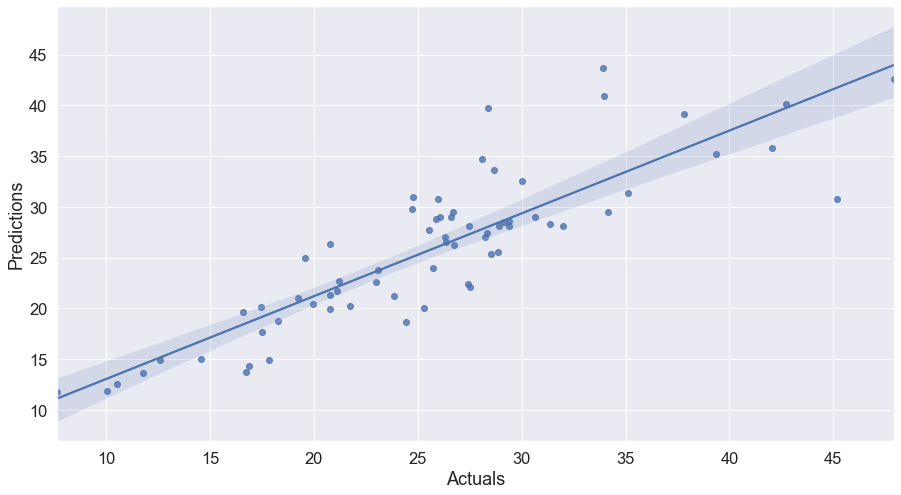

In [11]:
y_pred = pipe.predict(X_test)
evaluate_from_preds(y_test, y_pred)

This appears to be generalizing to our test data pretty well.

### Feature Importance

I want to look at the feature importance for the model so that I can get a better sense of what features played a role in prediction

In [12]:
fi = pd.DataFrame({'Feature Importance': pipe['train'].feature_importances_, 'Feature Name': preprocessing_feature_transformers.get_feature_names_out()})

In [13]:
fi.sort_values('Feature Importance',ascending=False, inplace=True)

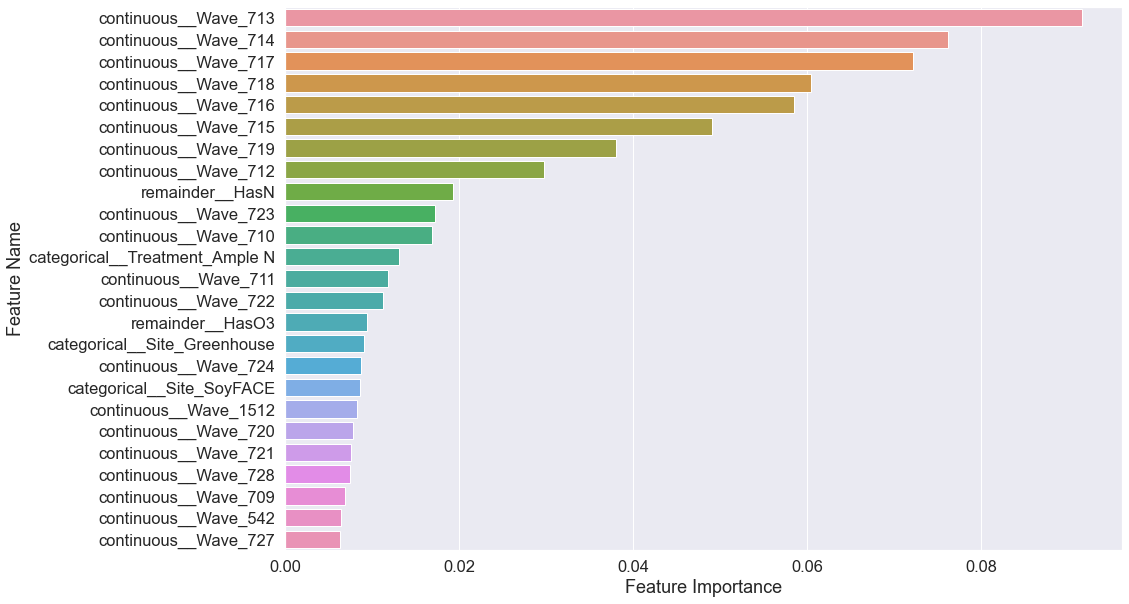

In [14]:
fig = plt.figure(figsize=(15,10))
feat = sns.barplot(x='Feature Importance', y='Feature Name', data=fi.iloc[:25], orient='h')

We can see here that the **wavelengths between 700-725, and more specifically 710-720, are the most import wavelengths for predicting this model**. I will reduce the number of wavelengths trained on to limit the amount of noise from other wavelengths. It also lookes like the **Site** is determinent of Chlorophyll concentration, as well as the **N and [03] Treatments** treatment process.

 ### Reducing the Number of Wavelengths Trained On

In [15]:
continuous = [f'Wave_{num}' for num in range(700, 726)]
continuous = pd.Index(continuous)

After iterating on the model, it appears some of the feature engineering actually increases the error of the model. I will drop these as well from the final model.

In [16]:
preprocessing_feature_transformers = ColumnTransformer(
    [
        ('continuous', preprocessing.StandardScaler(), continuous),
        ('categorical', preprocessing.OneHotEncoder(), categorical),
    ],
    remainder='drop'
)

In [17]:
pipe = Pipeline(
    [
        ('preprocessing', preprocessing_feature_transformers),
        ('train', RandomForestRegressor())
    ]
)

In [18]:
pipe.fit(X_train, y_train)

/Users/kevin-ironside/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('continuous',
                                                  StandardScaler(),
                                                  Index(['Wave_700', 'Wave_701', 'Wave_702', 'Wave_703', 'Wave_704', 'Wave_705',
       'Wave_706', 'Wave_707', 'Wave_708', 'Wave_709', 'Wave_710', 'Wave_711',
       'Wave_712', 'Wave_713', 'Wave_714', 'Wave_715', 'Wave_716', 'Wave_717',
       'Wave_718', 'Wave_719', 'Wave_720', 'Wave_721', 'Wave_722', 'Wave_723',
       'Wave_724', 'Wave_725'],
      dtype='object')),
                                                 ('categorical',
                                                  OneHotEncoder(),
                                                  Index(['Site', 'Growing Season', 'Genotype_Cleaned', 'Treatment'], dtype='object'))])),
                ('train', RandomForestRegressor())])

R2: 0.7905066647973217
MAE: 2.6699825912313457
MSE: 13.571198184556401


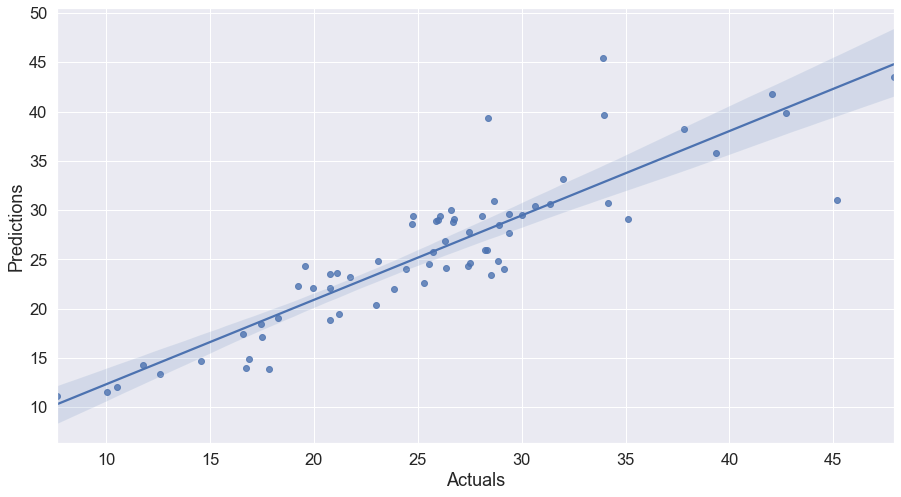

In [19]:
y_pred = pipe.predict(X_test)
evaluate_from_preds(y_test, y_pred)

This increased our models R2 from 0.740 to 0.791! It appears we have a tighter fit of our data for Actuals in the range of 10-30, and does not appear to have problems with overfitting. Serializing the model for use later on.

In [20]:
from joblib import dump
dump(pipe, '../src/RandomForestPipeline.joblib')

['../src/RandomForestPipeline.joblib']

### Future Improvement

Future improvement could look at:
* Generating some more robust features from wavelengths using feature engineering. 
* I could also look to tune hyperparameters with GridSearchCV for our model, rather than just using the default values. 
* It appears that maize with higher Chlorophyll content is harder to classify (you can see this in the residuals scatterplot above). It might be worthwhile to analyze the specific data points whose predictions are deviating from the trend line.
* Lastly, it is usually helpful to get more data! Particularly for higher chlorophyll contents where predictions are poor relative to the rest of the data, having more data points in this range could help us reduce the overall error.